# MNIST Classifier Noisy BNN Model

This script will train an MNIST classifier model. After which, noisy layers are introduced to observe how the accuracy drops.

### Setup

In [ ]:
pip install larq

In [37]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [304]:
import numpy as np
import tensorflow as tf
import larq as lq
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from scipy import interpolate
import pandas as pd
import math

### Download and prepare the MNIST dataset

In [38]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

# Normalize pixel values to be between -1 and 1
train_images, test_images = train_images / 127.5 - 1, test_images / 127.5 - 1

### Create the model


In [72]:
wargs = dict(#input_quantizer="ste_sign",
              kernel_quantizer="ste_sign",
              kernel_constraint="weight_clip")
my_seed = None

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))

model.add(tf.keras.layers.GaussianNoise(stddev=0, seed=my_seed)) # CBA1 noise
model.add(lq.layers.QuantDense(50, use_bias=False, 
                               activation=tf.keras.layers.Activation("tanh"),
                               **kwargs))

model.add(tf.keras.layers.GaussianNoise(stddev=0, seed=my_seed)) # CBA2 noise
model.add(lq.layers.QuantDense(10, use_bias=False, 
                               activation=tf.keras.layers.Activation("tanh"),
                               **kwargs))
model.add(tf.keras.layers.Activation("tanh"))
lq.models.summary(model)

+sequential_17 stats-----------------------------------------------------+
| Layer             Input prec.    Outputs  # 1-bit  Memory  32-bit MACs |
|                         (bit)                 x 1    (kB)              |
+------------------------------------------------------------------------+
| flatten_17                  -  (-1, 784)        0       0            0 |
| gaussian_noise_4            -  (-1, 784)        0       0            ? |
| quant_dense_29              -   (-1, 50)    39200    4.79        39200 |
| gaussian_noise_5            -   (-1, 50)        0       0            ? |
| quant_dense_30              -   (-1, 10)      500    0.06          500 |
| activation_44               -   (-1, 10)        0       0            ? |
+------------------------------------------------------------------------+
| Total                                       39700    4.85        39700 |
+------------------------------------------------------------------------+
+sequential_17 summary---

### Compile and train the model

In [63]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels,
                    batch_size=64, epochs=32, validation_split=0.2)

test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test loss {test_loss * 100:.2f} %")
print(f"Test accuracy {test_acc * 100:.2f} %")

Epoch 1/32
750/750 [==============================] - 4s 5ms/step - loss: 2.0879 - accuracy: 0.1997 - val_loss: 1.8751 - val_accuracy: 0.2610
Epoch 2/32
750/750 [==============================] - 3s 4ms/step - loss: 1.7872 - accuracy: 0.3741 - val_loss: 1.6717 - val_accuracy: 0.5070
Epoch 3/32
750/750 [==============================] - 3s 4ms/step - loss: 1.6241 - accuracy: 0.5659 - val_loss: 1.5811 - val_accuracy: 0.5998
Epoch 4/32
750/750 [==============================] - 3s 4ms/step - loss: 1.5530 - accuracy: 0.6448 - val_loss: 1.5046 - val_accuracy: 0.7012
Epoch 5/32
750/750 [==============================] - 3s 4ms/step - loss: 1.4882 - accuracy: 0.7181 - val_loss: 1.4472 - val_accuracy: 0.7495
Epoch 6/32
750/750 [==============================] - 3s 4ms/step - loss: 1.4444 - accuracy: 0.7551 - val_loss: 1.4135 - val_accuracy: 0.7772
Epoch 7/32
750/750 [==============================] - 3s 4ms/step - loss: 1.4070 - accuracy: 0.7818 - val_loss: 1.3770 - val_accuracy: 0.8008
Epoch 

### Evaluate the model

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


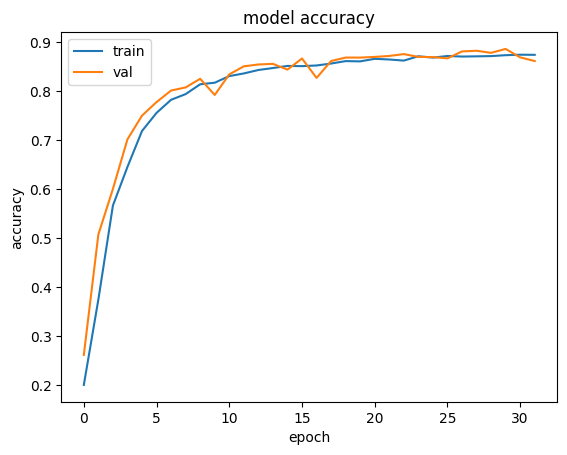

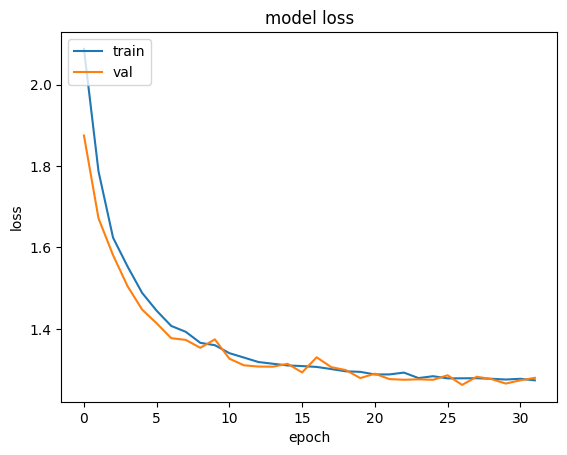

In [65]:
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Preview weights

In [66]:
#model.save("full_precision_model.h5")  # save full precision latent weights
fp_weights = model.get_weights()  # get latent weights

with lq.context.quantized_scope(True):
    #model.save("binary_model.h5")  # save binarized weights
    weights = model.get_weights()  # get binarized weights

In [67]:
from IPython.display import HTML
HTML(pd.DataFrame(weights[1].T).to_html())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0
1,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0
2,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0
3,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0
5,1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0
6,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0
7,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0
8,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,-1.0
9,-1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,1.0


### Test with the noise

In [110]:
# Create GaussianNoise for Inference
# https://github.com/keras-team/keras/blob/v2.11.0/keras/layers/regularization/gaussian_noise.py#L28-L81
class GaussianNoiseForInference(tf.keras.layers.GaussianNoise):
    def call(self, inputs, training=None):
        # Override to always use noisy function
        return super(GaussianNoiseForInference, self).call(inputs, training=True)

In [141]:
def evaluate_noise_model(T, HRS=11000, LRS=500, debug=True):
    kwargs = dict(#input_quantizer="ste_sign",
                  kernel_quantizer="ste_sign",
                  kernel_constraint="weight_clip")
    cba1_sd = math.sqrt(768) * T / HRS * LRS / 1.75
    cba2_sd = math.sqrt(50) * T / HRS * LRS / 1.75
    my_seed = None

    if debug:
        print("cba1_sd", cba1_sd)
        print("cba2_sd", cba2_sd)

    model2 = tf.keras.models.Sequential()
    model2.add(tf.keras.layers.Flatten(input_shape=(28, 28)))

    model2.add(GaussianNoiseForInference(stddev=cba1_sd, seed=my_seed)) # CBA1 noise
    model2.add(lq.layers.QuantDense(50, use_bias=False, 
                                   activation=tf.keras.layers.Activation("tanh"),
                                   **kwargs))

    model2.add(GaussianNoiseForInference(stddev=cba2_sd, seed=my_seed)) # CBA2 noise
    model2.add(lq.layers.QuantDense(10, use_bias=False, 
                                   activation=tf.keras.layers.Activation("tanh"),
                                   **kwargs))
    model2.add(tf.keras.layers.Activation("tanh"))
    if debug: lq.models.summary(model2)

    model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

    model2.set_weights(weights)

    test_loss2, test_acc2 = model2.evaluate(test_images, test_labels, verbose="auto" if debug else 0)

    if debug:
        print()
        print(f"Original Test loss {test_loss * 100:.2f} %")
        print(f"Original Test accuracy {test_acc * 100:.2f} %")
        print()
        print(f"Noisy Test loss {test_loss2 * 100:.2f} %")
        print(f"Noisy Test accuracy {test_acc2 * 100:.2f} %")
        print()
        print(f"Change of accuracy {(test_acc2/test_acc-1) * 100:.2f} %")
    
    return cba1_sd, cba2_sd, test_acc2

In [142]:
evaluate_noise_model(T=0.0)

cba1_sd 0.0
cba2_sd 0.0
+sequential_82 stats---------------------------------------------------------------------+
| Layer                             Input prec.    Outputs  # 1-bit  Memory  32-bit MACs |
|                                         (bit)                 x 1    (kB)              |
+----------------------------------------------------------------------------------------+
| flatten_82                                  -  (-1, 784)        0       0            0 |
| gaussian_noise_for_inference_104            -  (-1, 784)        0       0            ? |
| quant_dense_155                             -   (-1, 50)    39200    4.79        39200 |
| gaussian_noise_for_inference_105            -   (-1, 50)        0       0            ? |
| quant_dense_156                             -   (-1, 10)      500    0.06          500 |
| activation_233                              -   (-1, 10)        0       0            ? |
+-----------------------------------------------------------------

(0.0, 0.0, 0.8582000136375427)

In [ ]:
results = []
contents = "T, HRS, LRS, cba1_sd, cba2_sd, test_acc2\n"

for HH in range(1, 100):
    for T100 in range(0, 100, 5):
        T = T100/100
        LRS = 100
        HRS = 1000*HH
        cba1_sd, cba2_sd, test_acc2 = evaluate_noise_model(T=T, HRS=HRS, debug=False)
        results.append([T, HRS, LRS, cba1_sd, cba2_sd, test_acc2])
        line = f"{T}, {HRS}, {LRS}, {cba1_sd}, {cba2_sd}, {test_acc2}"
        print(line)
        contents += line + '\n'

# Write to file
with open("results.txt", "w") as f:
    f.write(contents)

0.0, 1000, 0.0, 0.0, 0.8582000136375427
0.05, 1000, 0.39589732744431483, 0.10101525445522108, 0.7861999869346619
0.1, 1000, 0.7917946548886297, 0.20203050891044216, 0.6287000179290771
0.15, 1000, 1.1876919823329444, 0.3030457633656632, 0.4666999876499176
0.2, 1000, 1.5835893097772593, 0.4040610178208843, 0.35370001196861267
0.25, 1000, 1.979486637221574, 0.5050762722761054, 0.274399995803833
0.3, 1000, 2.3753839646658887, 0.6060915267313264, 0.22699999809265137
0.35, 1000, 2.7712812921102032, 0.7071067811865476, 0.19509999454021454
0.4, 1000, 3.1671786195545186, 0.8081220356417687, 0.17749999463558197
0.45, 1000, 3.563075946998833, 0.9091372900969897, 0.16369999945163727
0.5, 1000, 3.958973274443148, 1.0101525445522108, 0.15199999511241913
0.55, 1000, 4.354870601887463, 1.111167799007432, 0.13860000669956207
0.6, 1000, 4.7507679293317775, 1.2121830534626528, 0.1356000006198883
0.65, 1000, 5.1466652567760915, 1.3131983079178742, 0.12680000066757202
0.7, 1000, 5.5425625842204065, 1.41421

### Visualise Results

In [154]:
import csv

myresults = []
with open("results.txt") as csvfile:
    reader = csv.reader(csvfile)
    next(reader, None)  # skip the headers
    for row in reader:
        myresults.append([float(x.strip()) for x in row])

Plot test accuracy

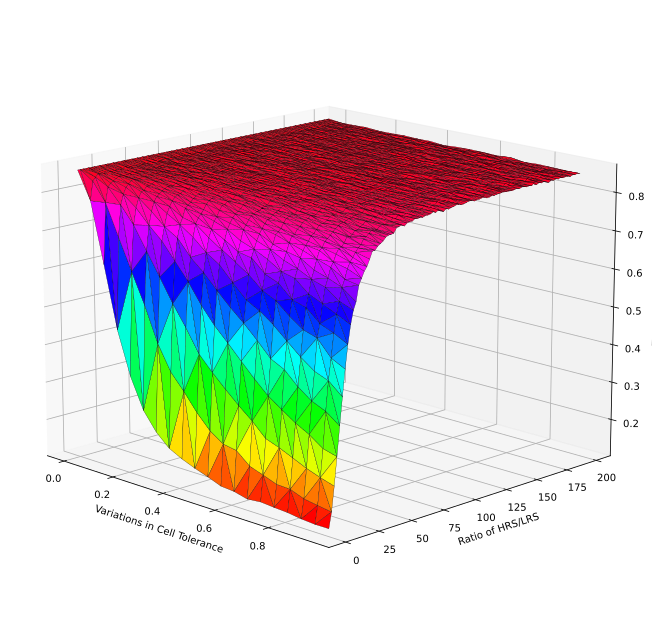

In [343]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

# Import libraries
import numpy as np
import matplotlib.pyplot as plt

# Creating dataset
x = np.array(list(map(lambda item: item[0], myresults)))
y = np.array(list(map(lambda item: item[1]/item[2], myresults)))
z = np.array(list(map(lambda item: item[-1], myresults)))

# Creating figure
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')
 
# Creating color map
# https://matplotlib.org/stable/gallery/color/colormap_reference.html
my_cmap = plt.get_cmap('hsv')

# Creating plot
ax.plot_trisurf(x, y, z,
                cmap=my_cmap,
                linewidth=0.25, edgecolors='k',
                antialiased=True);
# Show plot
ax.set_xlabel('Variations in Cell Tolerance')
ax.set_ylabel('Ratio of HRS/LRS')
ax.set_zlabel('Test Accuracy')
ax.view_init(elev=15, azim=315)

plt.tight_layout()
plt.show()

Plot test errors

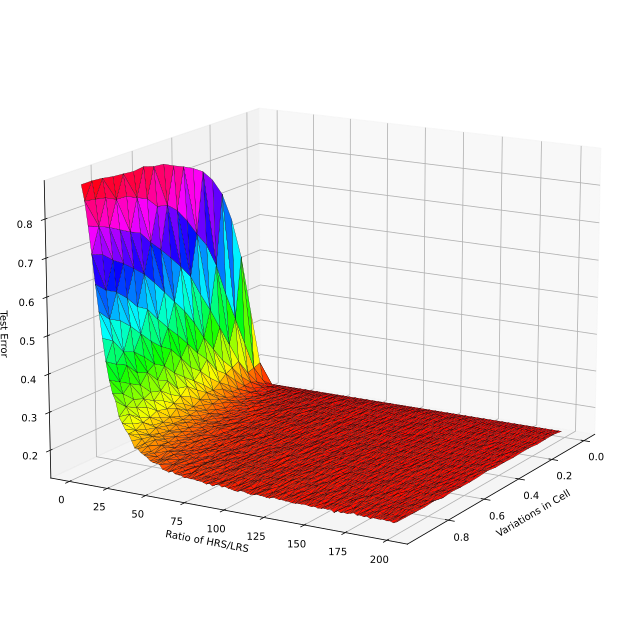

In [344]:
# Creating dataset
z = np.array(list(map(lambda item: (1-item[-1]), myresults)))

# Creating figure
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')

# Creating plot
ax.plot_trisurf(x, y, z,
                cmap=my_cmap,
                linewidth=0.25, edgecolors='k',
                antialiased=True);
# Show plot
ax.set_xlabel('Variations in Cell')
ax.set_ylabel('Ratio of HRS/LRS')
ax.set_zlabel('Test Error')
ax.view_init(elev=15, azim=30)
plt.tight_layout()
plt.show()

Show allowable degradation


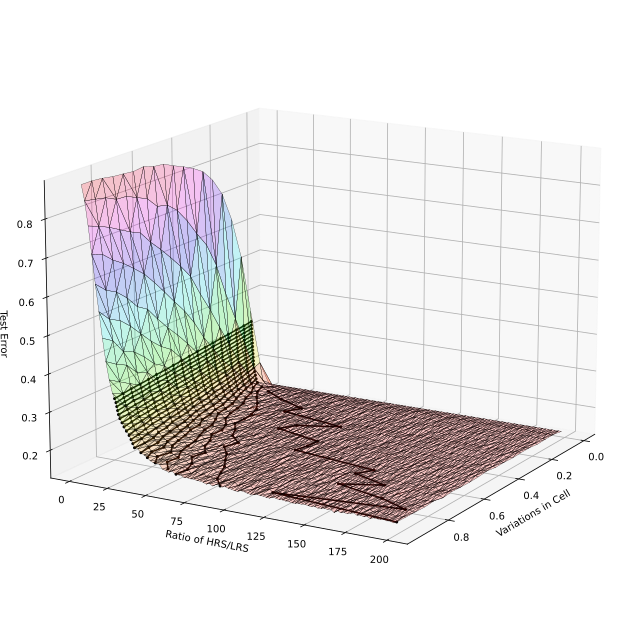

In [345]:
# Creating dataset
z = np.array(list(map(lambda item: (1-item[-1]), myresults)))

# Creating figure
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')

# Creating plot
ax.plot_trisurf(x, y, z,
                cmap=my_cmap, alpha=0.2,
                linewidth=0.25, edgecolors='k',
                antialiased=True);

def intersection_with_z_plane(_z, array_x, array_y, array_z):
    x_intersecting = []
    y_intersecting = []
    z_intersecting = []
    for _x in sorted(set(array_x))[2:]:
        condition = (array_x == _x)
        subset_y = np.extract(condition, array_y)
        subset_z = np.extract(condition, array_z)
        f = interpolate.interp1d(subset_z, subset_y, fill_value="extrapolate")
        _y = f(_z)
        
        x_intersecting.append(_x)
        y_intersecting.append(_y)
        z_intersecting.append(_z)        
    return (x_intersecting, y_intersecting, z_intersecting)

my_z_points = np.array(range(1, 20+1)) / 100
for z_point in my_z_points:
    z_point += min(z)
    pts = intersection_with_z_plane(z_point, x, y, z)
    ax.plot(*pts, 'black', marker='o', markersize=2)


# # Plot surface satisfying a condition
# condition = np.logical_and(x < 0.5, (z < 0.2))
# qx = np.extract(condition, x)
# qy = np.extract(condition, y)
# qz = np.extract(condition, z)
# ax.plot_trisurf(qx, qy, qz,
#                 cmap=clr.LinearSegmentedColormap.from_list('AllBlue', [(0, '#0000ff'), (1, '#0000ff')], N=256),
#                 linewidth=0.25, edgecolors='k',
#                 antialiased=True);

# Show plot
ax.set_xlabel('Variations in Cell')
ax.set_ylabel('Ratio of HRS/LRS')
ax.set_zlabel('Test Error')
ax.view_init(elev=15, azim=30)
plt.tight_layout()
plt.show()

---